## Enviroment:

Open AI gym [CartPole v0](https://github.com/openai/gym/wiki/CartPole-v0)

### Observation

Type: Box(4)

| Num  | Observation          | Min      | Max     |
| :--- | :------------------- | :------- | :------ |
| 0    | Cart Position        | -2.4     | 2.4     |
| 1    | Cart Velocity        | -Inf     | Inf     |
| 2    | Pole Angle           | ~ -41.8° | ~ 41.8° |
| 3    | Pole Velocity At Tip | -Inf     | Inf     |

### Actions

Type: Discrete(2)

| Num  | Action                 |
| :--- | :--------------------- |
| 0    | Push cart to the left  |
| 1    | Push cart to the right |

Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it

### Reward

Reward is 1 for every step taken, including the termination step

### Starting State

All observations are assigned a uniform random value between ±0.05

### Episode Termination

1. Pole Angle is more than ±12°
2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
3. Episode length is greater than 200

### Solved Requirements

Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials

## 1. gym enviroment setup

In [1]:
import gym
import numpy as np

import matplotlib.pyplot as plt
env = gym.make("CartPole-v0")
env.reset()

array([ 0.01212204,  0.00559549,  0.03346642, -0.01407475])

In [2]:
import tensorflow as tf
from tqdm import tqdm

In [3]:
ACTION_SPACE_SIZE = env.action_space.n
OBSERVATION_SPACE_SIZE = env.observation_space.shape[0]

# reward discount
GAMMA = 0.95
EPISODES =30000

ep_rewards = []

AGGREGATE_STATS_EVERY = 50

## 3. Agent Class

In [12]:
class DQNAgent:

  def __init__(self):

    # build nn network
    self._build_net()
    
    self.sess = tf.Session()

    self.sess.run(tf.global_variables_initializer())

    
    
  # build the policy modle a two layer neural network  
  def _build_net(self):
    self.states = tf.placeholder(tf.float32, [None,OBSERVATION_SPACE_SIZE])
    self.actions = tf.placeholder(tf.int32, [None,])
    self.discounted_episode_rewards = tf.placeholder(tf.float32, [None,])

    fc1 = tf.layers.dense(
        inputs = self.states,
        units = 10,
        activation = tf.nn.relu,
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
        bias_initializer=tf.constant_initializer(0.1)
    )
    
#     fc2 = tf.layers.dense(
#         inputs = fc1,
#         units = 10,
#         activation = tf.nn.relu,
#         kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
#         bias_initializer=tf.constant_initializer(0.1)
#     )
    

    act_logits = tf.layers.dense(
        inputs = fc1,
        units = ACTION_SPACE_SIZE,
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
        bias_initializer=tf.constant_initializer(0.1),
    )

    self.actions_prob = tf.nn.softmax(act_logits)
    
    #sample an action from predicted probabilities    
    self.sample_op = tf.multinomial(logits=act_logits, num_samples=1)

    neg_log_prob = tf.reduce_sum(-tf.log(self.actions_prob) * tf.one_hot(self.actions, ACTION_SPACE_SIZE),axis =1)
#     neg_log_prob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=act_logits, labels=self.actions)
    loss = tf.reduce_mean(neg_log_prob * self.discounted_episode_rewards)

    self.train_op = tf.train.AdamOptimizer(0.001).minimize(loss)

#   def choose_action(self, states):
#     actions_prob = self.sess.run(self.actions_prob, feed_dict = {self.states : states[np.newaxis,:]})
#     action = np.random.choice(range(actions_prob.shape[1]),p = actions_prob.ravel())
#     return action

  def choose_action(self, states):
    action = self.sess.run(self.sample_op, feed_dict={self.states: states[np.newaxis,:]})
    return action[0][0]
  
  def train(self, states, actions, rewards):
    discounted_episode_rewards = self.discount_rewards(rewards)
    self.sess.run(self.train_op,
                  feed_dict = {self.states : states,
                               self.actions : actions,
                               self.discounted_episode_rewards : discounted_episode_rewards }
                  )

  def discount_rewards(self, rewards):
    discount_rewards = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(len(rewards))):
      running_add = running_add * GAMMA + rewards[t]
      discount_rewards[t] = running_add

      mean = np.mean(discount_rewards)
      std = np.std(discount_rewards)
      discount_rewards = (discount_rewards - mean)/std

      return discount_rewards

In [13]:
agent = DQNAgent()

## 4. Train the agent

In [14]:
aggr_ep_rewards = {'ep':[],'avg':[],'min':[],'max':[]}

In [15]:
# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
    # Restarting episode - reset episode states,actions, and rewards 
    episode_states, episode_actions, episode_rewards = [],[],[]
    
    #Reset single step reward
    episode_reward = 0

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        action = agent.choose_action(current_state)
        next_state, reward, done, _ = env.step(action)

        # Store [s a r]
        episode_states.append(current_state)
        episode_actions.append(action)
        episode_rewards.append(reward)


        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

#         if not episode % AGGREGATE_STATS_EVERY:
#             env.render()

        current_state = next_state

    agent.train(np.vstack(episode_states), np.array(episode_actions), np.array(episode_rewards))
    
    
    # Append episode reward to a list and log rewards (every given number of episodes)
    ep_rewards.append(episode_reward)

    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['min'].append(min_reward)
        aggr_ep_rewards['max'].append(max_reward)
        
#         agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)


100%|###################################################################| 30000/30000 [41:19<00:00, 12.67episodes/s]


## 5. Plot episodes vs rewards

Text(0,0.5,'Rewards')

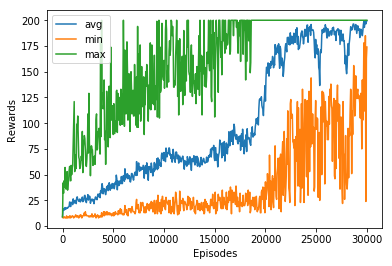

In [54]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label = 'avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label = 'min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label = 'max')
plt.legend(loc='upper left')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

Text(0,0.5,'Rewards')

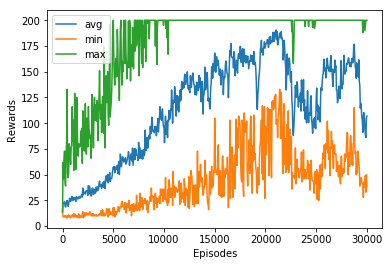

In [16]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label = 'avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label = 'min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label = 'max')
plt.legend(loc='upper left')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

### Rendering Test

In [21]:
done = False
state = env.reset()
for i in range(500):
# while not done:
    action = agent.choose_action(state)
    next_state, _, done, _ = env.step(action)
    state = next_state
    env.render()

env.close()
    